<a href="https://colab.research.google.com/github/frank-895/machine_learning_journey/blob/main/gradient_boosting_machine/gbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from fastai.tabular.all import *
from fastai.data.transforms import IndexSplitter

# Gradient Boosting Machines - Forecasting Sticker Sales

## Introduction

After learning about **ensembles of decision trees** as an approach to modelling tabular data, I've decided to have another shot at the [Forecasting Sticker Sales](https://www.kaggle.com/competitions/playground-series-s5e1) Kaggle competition.

While I initially approached the problem with **deep learning** and scored in the top 27% of predictions, I want to see if I can improve on this by taking a different approach.

In my last notebook I uncovered **random forests** which is one approach of ensembling decision trees. However, there is another area of ensembling I wish to learn more about, called **gradient boosting machines (GBMs)**.

Since I've already gone into detail in my [previous notebook](https://github.com/frank-895/machine_learning_journey/tree/main/random_forests) about how decision trees are made and what ensembling is, I will be focusing on *building* that knowledge. I won't go into detail about when to use **ensembles of decision trees** vs **deep learning**.

Furthermore, I've selected a **regression** problem for this project, as I practiced a **classification** problem when learning random forests.

The first thing to establish is the key differences between **random forests** and **GBMs**.

Where random forests utilise **bagging** (training each model on a different data subset and averaging), GBMs use **boosting**, where models are 'added'. Each new decision tree correct the errors made by the previous models and the final prediction is the the weighted sum of all the predictions from all the models.

GBMs can generally perform better than random forests, but they are more complicated to implement.
- They require some fussing with hyperparamaters.
- They are prone to overfitting as each tree is not independent of the others.
- They are rely on sequential training, which is slower, whereas random forests can utilise parallel training (as they are independent trees).

So, a good approach would be to start with a random forest, then try a GBM. We will do that here, but the description for random forests will be brief as we have already gone into detail about this previously.

## Data Engineering

Let's start with our data.

In [2]:
df = pd.read_csv('train.csv')
df.isnull().sum()

,0
id,0
date,0
country,0
store,0
product,0
num_sold,8871


We will drop training rows missing the independent variable to focus on learning the concept of GBMs.

Normally, with features missing values (there are none here) we would fill numerical features with the mean/median/mode and categorical features with a placeholder like 'Unknown' as the fact that data is missing can still be useful information to train a model.

In [3]:
df.dropna(axis=0, inplace=True)
df

,id,date,country,store,product,num_sold
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


Now, we will perform much of the same **feature engineering** as the deep learning approach. Since tree-based models are robust to non-normality, log transformations will not be used in this approach on any predictors; however, we will perform a log transformation on the `num_sold` column as our predictions are highly skewed with a long right tail (shown in the last notebook).

As previously discussed, OHE is generally not needed for tree-based approaches.

In [4]:
%%capture
df['num_sold'] = np.log1p(df['num_sold'])

# extract useful features from date
add_datepart(df, 'date')

# drop unneeded columns
df.drop('id', axis=1, inplace=True)

Now, we can define a training and validation set. Since we are working with data over time, we will clip the end of the df and use this as our **validation set**.

I am going to be using a new techinque I recently learn for this, defined by `TabularPandas`. `TabularPandas` sits on top of a pandas df and is provided by `fastai`. This class modifies objects in place and runs transformations when data is passed in, rather than lazily as data is accessed.

In [5]:
procs = [Categorify, FillMissing]

These two transformations are not strictly necessary on this dataset as we have no missing values in the predictor columns. However, `FillMissing` is a `TabularProc` (much like a `Transform` in pandas) that  replaces missing values with median values. `Categorify` is a new feature that is set `True` for any row where the value was missing (as missing values can hold valuable information for training). We will pass the `TabularProc`s when creating our training and validation sets.

In [6]:
cond = df.Year<2016
train_idx, valid_idx = np.where(cond)[0], np.where(~cond)[0]
splits = (list(train_idx),list(valid_idx))

`where()` is a useful function returning indices of all True values.

We also want to define our **categorical** and **continuous** variables before creating our `TabularPandas`. While we did this manually last time, we can actually benefit from the `fastai` function `cont_cat_split` that can automtically infer the variable type.

In [7]:
cont, cat = cont_cat_split(df, dep_var="num_sold")
cont, cat

(['Week', 'Day', 'Dayofyear', 'Elapsed'],
 ['country',
  'store',
  'product',
  'Year',
  'Month',
  'Dayofweek',
  'Is_month_end',
  'Is_month_start',
  'Is_quarter_end',
  'Is_quarter_start',
  'Is_year_end',
  'Is_year_start'])

Now we are ready for our `TabularPandas`!

In [8]:
data = TabularPandas(df, procs, cat, cont, y_names="num_sold", splits=splits)
len(data.train), len(data.valid)

(189492, 31767)

## Random Forest

### Making the Model

Let's build a random forest! While I have previously discussed in-depth how **random forests** work, I am now using a random forest for a **regression** task for the first time.

**How does the decision tree predict a continuous value?**

Each decision tree will output a numerical value for a data point, which is the mean of the target values of the training samples in the leaf node where the data point falls.

**But how does the model decide where to make the split at each binary split?**

The model will calculate and minimise the **variance** also known as **minimizing impurity**. Just like a classification task, the model will see how similar the targets of each data point are for each possible split. Instead of just comparing if they are the same or different though, it will use a formula called the **weighted average variance**. This basically means that values that are closer together will have a lower **impurity** and this split will be prioritised.

This explains how a decision tree performs a regression task as opposed to a classification task.

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1, # no of jobs to run in parallel, -1 means use all CPUs
                           n_estimators=100, # no trees
                           max_features=0.5, # no of columns to sample at each split point
                           min_samples_leaf=3, # min number of data points in leaf nodes
                           max_samples=0.75, # how many rows to sample for each training tree
                           oob_score=True) # we use oob to claculate the out-of-bag error later

rf.fit(data.train.xs, data.train.y)
y_pred = rf.predict(data.valid.xs)

Now that we have our predictions, let's evaluate them using **mean absolute percentage error** (MAPE), which is the defined metric for this Kaggle competition.

In [10]:
import numpy as np

def mape(y_actual, y_pred, epsilon=1e-10):
  y_actual = np.array(y_actual)
  y_pred = np.array(y_pred)

  mape = np.mean(np.abs((y_actual - y_pred) / (y_actual + epsilon)))
  return mape

mape(data.valid.y, y_pred)

0.01948954560857891

### Out-of-bag Error

At this point, we're going to find a new way of measuring the prediciton error on the trainin set, by using only the calculation of a row's error trees where that rows was not included in the training.

Since every tree is trained on a different random subset of rows, we can imagine that every tree has its own validation set, which is the rows that were not selected for that tree's training. The prediction error calculated on these remaining rows is called the **out-of-bag (OOB) error**.

This is useful if we don't have much data (so perhaps not useful here), as we can see whether our model generalises without needing to separate data for a validation set.

This is why when training the model we activated the parameter `oob_score`.

In [12]:
mape(rf.oob_prediction_, data.train.y)

0.008896529053385985

We can see that the out-of-bag error is much lower than our validation set error - since OOB samples are still part of the overall training set, they are not entirely independent of the training process, making an optimistic (but nevertheless useful) performance estimate.

### Submitting Predictions

At this point, I'm going to make some predictions on the test dataset and submit to Kaggle, just to see where we are at!

I ran into some issues here, as the data pipeline for the model requires a `TabularPandas`. Since it appears this class was designed for neural networks with fastai - which inherintly hold information about the data formatting - I can't seem to find a way to add a test set to my pre-exisiting `TabularPandas` object. The code below is a bit messy, and the test_data is stored in `.train`. If anyone has a better way of approaching this, I would love to know!

In [13]:
%%capture
test_df = pd.read_csv('test.csv')
add_datepart(test_df, 'date')

test_data = TabularPandas(test_df, procs, cat, cont)

test_df['num_sold'] = rf.predict(test_data.train.xs)
test_df['num_sold'] = np.expm1(test_df['num_sold'])
sub_df = test_df[['id', 'num_sold']]

sub_df.to_csv('submission.csv', index=False)

So, after submitting the results of our predictions on the test data, we were scoring a MAPE of 0.162! This is not a bad prediction considering our deep learning result was sitting around this prior to optimisation!

## Gradient Boosting Machine

### Making the Model

I can now try out the `GradientBoostingRegressor` also provided by sklearn.

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(
    n_estimators = 100,
    learning_rate=1,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=3
)

gbm.fit(data.train.xs, data.train.y)

y_pred = gbm.predict(data.valid.xs)

mape(data.valid.y, y_pred)

0.02168047853938121

As you can see above, the model requires a lot more playing around with hyperparameters and it also took significantly longer to train.

The **learning rate** in a GBM is used to scale the contribution of each new weak decision tree to the final model. A smaller learning rate means smaller updates to the model, while a larger learning rate means larger updates to the model. You use the learning rate in GBMs much like you would in a NN - you don't want the value to big or too small.

### Submitting Predictions

In [15]:
%%capture
test_df = pd.read_csv('test.csv')
add_datepart(test_df, 'date')

test_data = TabularPandas(test_df, procs, cat, cont)

test_df['num_sold'] = rf.predict(test_data.train.xs)
test_df['num_sold'] = np.expm1(test_df['num_sold'])
sub_df = test_df[['id', 'num_sold']]

sub_df.to_csv('submission2.csv', index=False)

I used the model on the test set (as above) and after playing around with the hyperparameters I was able to get a MAPE value of 0.164, slightly worse than the random forest.

While we weren't able to improve on the result generated by our NN in the competition, there is other useful information we can derive from our **ensembles of decision trees**.

## Prediction Confidence

Another useful piece of information we can derive from an ensemble of decision trees is the standard deviation of the predictions across trees.

While the mean will provide the estimate, the standard deviation will provide **the confidence**, as it will show if each tree agrees with the others or not. A low standard deviation indicates high confidence, whereas a high standard deviation represents a low confidence.

This would be useful if you were making critical decisions based on the model - if the model was not confident in its prediction it might make you think twice before doing something rash.

We will use Numpy to make this prediction, as it is optimised to work with large matrices.

- `gbm.estimators_` is a list of all 100 `DecisionTreeRegressor`s that makes up the gradient boosting machine.
- `tree` is a list containing the `DecisionTreeRegressor` at position 0 and the data type in position 1.
- `data.valid.xs.to_numpy()` takes our `TabularPandas` of all validation feeatures and converts it to a numpy array
- We calculate each decision tree's prediction of each data point in the validation set, returning a list of a list of predictions using `predict()`.


In [27]:
preds = np.stack([tree[0].predict(data.valid.xs.to_numpy()) for tree in gbm.estimators_])
preds.shape

(100, 31767)

Now that we have 100 tree's predictions of 31,767 data points, we can stack those predictions and calculate the standard deviation across the 0th axis (i.e., the axis containing 100 decision trees).

In [25]:
preds_std = preds.std(0)
preds_std.max(), preds_std.min()

(0.41395298975817885, 0.0023943965717917568)

We can see the value of this calculation by comparing the highest standard deviation and the lowest - there is a big difference between the model's level of confidence (197.7%). This would be very important to gauge if using the model to predict a piece of data.

## Feature Importance

We can also use the **ensembles of decision trees** to determine how much each feature contributes to the improvement of the model. Scikit-learn has a great feature to help us calculate that.

In [29]:
df.columns

Index(['country', 'store', 'product', 'num_sold', 'Year', 'Month', 'Week',
       'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed'],
      dtype='object')

In [38]:
pd.options.display.float_format = '{:.3f}'.format # prevent scientific notation
fi = pd.DataFrame({'cols':cat+cont, 'imp':gbm.feature_importances_}).sort_values('imp', ascending=False)

Now, we can plot this data.

<Axes: ylabel='cols'>

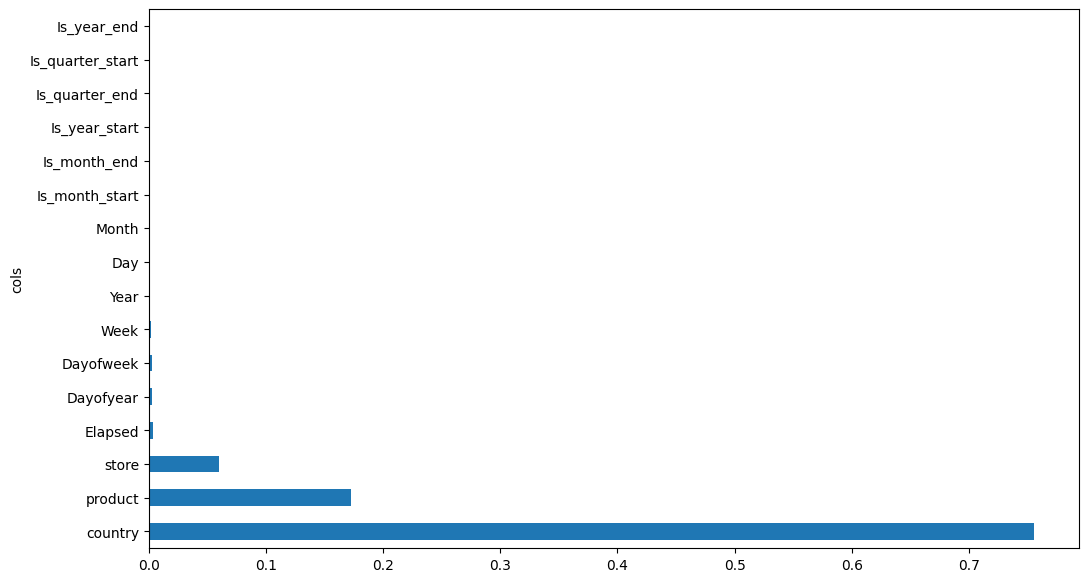

In [39]:
fi.plot('cols','imp','barh', figsize=(12,7), legend=False)

This is a really interesting discovery. Essentially, only 3 features actually contribute to our decision tree's performance:
- `country`
- `product`
- `store`

These are the three features we didn't play around with at all. This indicates that either the date of sale is not a useful indicator of sales, or that we've done a poor job of feature engineering it.

Since the purpose of this notebook is to work on understanding **ensembles of decision trees**, I won't go further into improving the model. But this does give us valuable insight into the power of this modelling technique. If we were working with thousands and thousands of features, this would be a very easy way to immediately eliminate unhelpful features.

## Remove Low-importance Variables

Let's get rid of the low-importance variables (those with a feature performance < 0.01) and see how it affects the model's performance.

In [40]:
to_keep = fi[fi.imp>=0.01].cols
len(to_keep)

3

Now, we will retrain the model.

In [56]:
xs_imp = data.train.xs[to_keep]
valid_xs_imp = data.valid.xs[to_keep]
gbm2 = GradientBoostingRegressor(
    n_estimators = 100,
    learning_rate=1,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=3
)

gbm2.fit(xs_imp, data.train.y)

y_pred = gbm2.predict(valid_xs_imp)

mape(data.valid.y, y_pred)

0.03336315076930216

That trained in less then a second and our MAPE has barely changed!

## Partial Dependence

**Partial dependence** measures the relationship between a subset of input features and the predicted outcome of a model. We can use partial dependence to understand the relationship between our predictors and sticker sales.

Let's start by looking at  the count of values per category.

([<matplotlib.axis.YTick at 0x7edfdeba4c50>,
 [Text(0, 0, 'Canada'),
  Text(0, 1, 'Finland'),
  Text(0, 2, 'Italy'),
  Text(0, 3, 'Kenya'),
  Text(0, 4, 'Norway'),
  Text(0, 5, 'Singapore')])

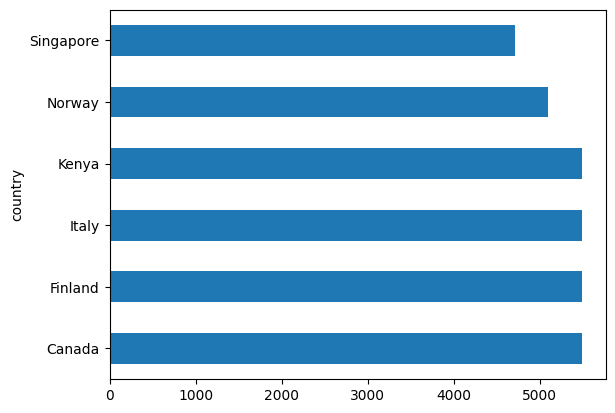

In [57]:
p = valid_xs_imp['country'].value_counts().plot.barh()
c = data.classes['country'][1:] # position 0 is for null values, we have none
plt.yticks(range(len(c)), c)

We are going to just calculate the partial dependence on our most predictive feature.

**Partial dependence plots** answer the question: if a row varied on nothing other than the feature(s) in question, how would it impact the dependent variable? What we do, is replace every single value in the `country` column with `Canada` then take the average over all the auctions. We repeat for `Finland`, `Italy`, and so forth.

In [64]:
c

(#6) ['Canada','Finland','Italy','Kenya','Norway','Singapore']

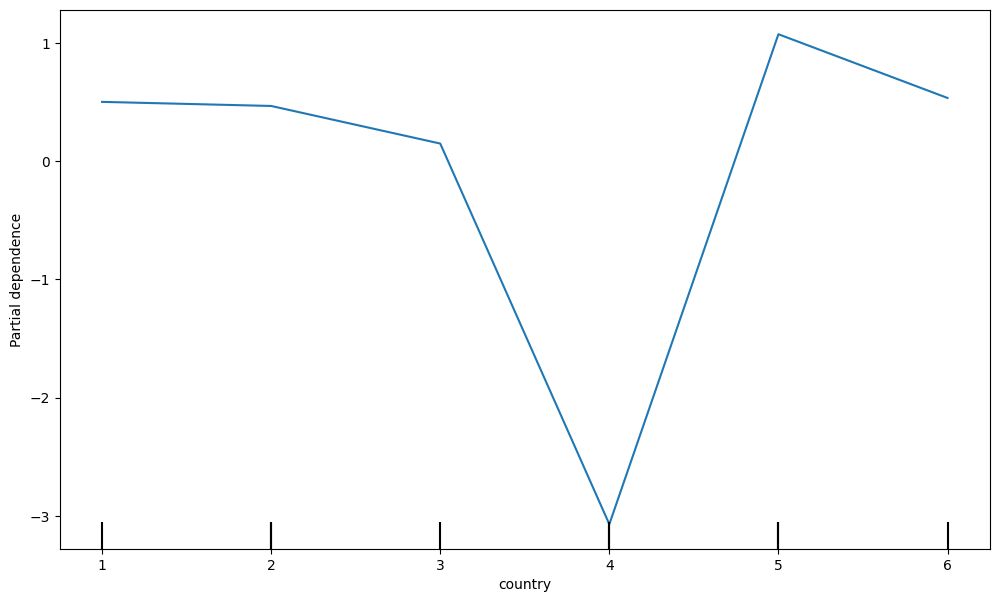

In [82]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 7))

PartialDependenceDisplay.from_estimator(gbm2, valid_xs_imp, ['country'], ax=ax)

plt.show()

This is very insightful - it is essentially telling us that sales from `5`, which corresponds to `Norway`, results in a much higher number of sales. Alternatively, sales from `4`, corresponding to `Kenya`, results in a much lower level of sales.

## Waterfall Charts

Another useful piece of information we can derive from ensembles of decision trees, is what the most important factors are in making a prediction for a particular row of data.

We can use the `waterfallcharts` library to understand this.

Let's say we are looking at a particular data entry that has predicted a really high number of sales. We want to understand why it's been predicted as having a really high number of sales. So, we take this row of data an put it through the decision tree. At each level of the decision tree, we what the increase or decrease in the prediction is.

While technically you can perform this on GBM, it makes more sense to perform it on a **random forest**. Random forests consist of single decision trees that can be independently interpreted, where as GBMs build cumulatively, so we can't just pass our prediction through a single **estimator** (or decision tree). So, we will use our random forest model to visualise the **waterfall chart**.

Let's start by installing dependencies.

In [91]:
%%capture
!pip install treeinterpreter
!pip install waterfallcharts

Now, we can take the first row of validation data.

In [109]:
row = data.valid.xs.iloc[:1]

In [110]:
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

pred, bias, cont = treeinterpreter.predict(rf, row.values)

- `pred` represents the prediction the random forest makes.
- `bias` is the starting point, as **the decision tree begins with a certain base prediction**. In a regression model, this is the average value of the target variable across all training data.
- `cont` is what is interesting to us. It tells us the total change in prediction due to each of the independent variables. This means `cont.sum()` is the models final prediction.

In [111]:
cont, cont.sum()

array([[ 5.20224816e-01, -5.02621247e-01,  5.81039838e-01,
        -9.40199112e-04,  2.81878830e-04, -1.56760420e-02,
        -5.35762845e-04,  1.24408894e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  9.40642754e-04,
         4.52863830e-02, -4.27637887e-04,  5.81439979e-03,
         2.04699338e-02]])

/usr/local/lib/python3.11/dist-packages/waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/usr/local/lib/python3.11/dist-packages/waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

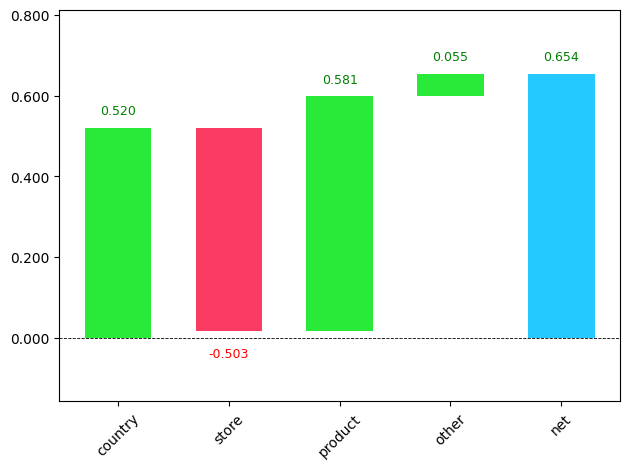

In [114]:
waterfall(data.valid.xs.columns, # list of column names
          cont.flatten(), # it's current 2 dimensional, so we flatten it
          threshold=0.08, # if a value is too small, don't inclde it
          rotation_value=45, # rotate the x axis titles
          formatting='{:,.3f}')

Look at this valuable information! We can see that the `country` value and `product` value increased its prediction by a substantial amount, while `store` decreased it.

The y-axis unit is the same as `num_sales`, which we took a log transformation of at the start. So, the final prediction of the model would be `exp1(0.654)`.

This information is more useful in **production** rather than **model development**.

## Limitations and Considerations

These are some limitations discussed in Chapter 9 of the [textbook](https://course.fast.ai/Resources/book.html) which I've reduced for my own understanding.

### Data Leakage

This is not a consideration only for ensembles of decision trees but for **all types of modelling**.

Data leakage occurs when information from outside the training data set 'leaks' to train the model, leading to overfitting.

The example given in the textbook revolves around a competition to predict which researchers would recieve a grant. The information that was given included info about the researchers and their research. A model was built performing with 95% accuracy.

The reason it turned out, was data leakage. One identifier column showed that the information was missing in this column **whenever** the university had rejected the grant. If using the model in practice, this information would obviously **not be available** - hence, data leakage.

How do we detect it?
- Check whether the accuracy is **too good to be true**.
- Look for important predictors that **don't make sense in practice**.
- Look for partial dependence plot results that **don't make sense in practice**.

### Extrapolation

An issue with ensembles of decision trees is that they struggle with **extrapolation**.

A decision tree simply predicts the average value of the rows in a leaf. Therefore, a decision tree, and by extension random forests and GBMs can never predict values outside the range of the training data. This can be problematic for data where there is a trend over time, such as inflation (or sticker sales!) and you wish to make predictions for a future time - the predictions will be systematically too low.  

This problem extends beyond time as **ensembles of decision trees** are not able to extrapolate outside of types of data they have seen in a more general sense. So, we need to make sure our **validation set does not contain out-of-domain data**.

Our dataset, which has only a few useful features, is not going to be suitable for a demonstration here. However, it is important to note that we can use random forests to **predict whether a row is in the validation set or the training set**. Then, we can get feature importance of this new random forest.

If certain features have high importance, it indicates that they contain information that varies greatly between the two datasets (hence, why the model uses it in its predictions). Oftentimes, removing these values can impove accuracy and make the dataset more resilient, easier to maintain and easier to understand. It will help the model generalise on the data, reducing overfitting.

What we are identifying here is called **domain shift**, which is where the distribution of data in the training set differs from the distribution of data in real-world data.

Sometimes, it's also useful to remove really old data which contains patterns which may no longer be useful. This applies more-so to temporal data, but is a useful paradigm - sometimes a subset of your data can produce better results. Bigger isn't always better.

## Conclusion

Before I wrap up this notebook, there's one more important discussion. We've talked about ensembling decision trees BUT, what if we ensembled a **neural network** and a **random forest**? This is actually a valid technique that can "add a nice little boost to any models that you have built." We don't do that here - the neural network is in a separate notebook. However, you can easily do this, by converting the PyTorch rank-2 tensor prediction to a rank-1 Numpy array and taking the mean of the two predictions!

This notebook has been a great insight into **ensembles of decision trees** as well as the useful information they can provide. Thank you to the [textbook](https://course.fast.ai/Resources/book.html) for its valuable content which I used to make this notebook!